# Character Recognition Model

## Importing Dependencies

In [1]:
import glob
import cv2 as cv
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [2]:
# get images whose frames are available
images=[]
img_names=[]
borders=[]
for path_string in glob.iglob('./train_bbxs/*txt'):
    borders.append(open(path_string,'r').read().splitlines())
    img_name = path_string[13:].split('.')[0]
    img_names.append(img_name)
    current_img = cv.imread('./train_images/'+img_name+'.jpg')
    images.append(cv.cvtColor(current_img,cv.COLOR_BGR2GRAY))

In [3]:
labels=pd.read_csv('./train_labels.csv')
train_data=pd.DataFrame({
    'img_name':[],
    'label':[]
})

for i in range(len(img_names)):
    img_number = int(img_names[i])
    train_data.loc[i] = [labels['img_name'][img_number],labels['label'][img_number]]
print(train_data)

       img_name    label
0     03445.jpg    ودل27
1     02365.jpg  ىرث5293
2     00431.jpg    طعم73
3     00221.jpg     ذى06
4     03565.jpg    شغ147
...         ...      ...
4978  03662.jpg     هس01
4979  01049.jpg    ظع279
4980  00773.jpg      صم1
4981  01511.jpg    غزش38
4982  04461.jpg   لف8711

[4983 rows x 2 columns]


In [4]:
# crop the images
# 2d array
cropped_images = []
for i,boxes in enumerate(borders):
    for box in boxes:
        points = box.split(',')
        #these are the 4 points defining the border of a character
        x1=int(points[0])
        y1=int(points[1])
        x2=int(points[2])
        y2=int(points[3]) 
        cropped_images.append(images[i][y1:y2,x1:x2])

In [5]:
result=[]
for label in train_data['label']:
    characters=label
    for i in range(len(characters)):
        result.append(characters[i])


In [2]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
data_path =os.path.join(os.getcwd() , "data")
if not os.path.exists(data_path):
    os.makedirs(data_path)

    
def generate_images(dataPath):
    
    alphabetlist = {
        "ا": 0,
        "ب": 1,
        "ت": 2,
        "ث": 3,
        "ج": 4,
        "ح": 5,
        "خ": 6,
        "د": 7,
        "ذ": 8,
        "ر": 9,
        "ز": 10,
        "س": 11,
        "ش": 12,
        "ص": 13,
        "ض": 14,
        "ط": 15,
        "ظ": 16,
        "ع": 17,
        "غ": 18,
        "ف": 19,
        "ق": 20,
        "ك": 21,
        "ل": 22,
        "م": 23,
        "ن": 24,
        "ه": 25,
        "و": 26,
        "ى": 27,
        "0": 28,
        "1": 29,
        "2": 30,
        "3": 31,
        "4": 32,
        "5": 33,
        "6": 34,
        "7": 35,
        "8": 36,
        "9": 37,
    }

    for idx in range(len(alphabetlist)):
        os.makedirs("{}/{}".format(dataPath, idx), exist_ok=True)
    for i in range (len(result)):     
        img = cropped_images[i]
#         print(alphabetlist[result[i]])
        path = f"./data/{alphabetlist[result[i]]}"
        if not os.path.exists(path):
            os.makedirs(str(alphabetlist[result[i]]))
        try:
            
            cv.imwrite(path+f"/{i}.jpg", img,[cv.IMREAD_GRAYSCALE])
            print("Success",path+f"/{i}.jpg")
        except:
            print("Error",path+f"/{i}.jpg")
            
generate_images(data_path)

NameError: name 'result' is not defined

# Build the prediction model

### We will use a transfered model for feature extraction and will change the finalo classification layer to suit the specified classes

In [2]:
import torch
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data.sampler import SubsetRandomSampler
use_cuda=torch.cuda.is_available()
print(use_cuda)

False


In [ ]:
# specify data loaders
batch_size = 32
# train_transform = transforms.Compose([transforms.CenterCrop(255),
# #                                       transforms.Resize(255),
#                                        transforms.RandomRotation(20),
#                                        transforms.ToTensor(),
#                                        transforms.Normalize([0.5],
#                                                     [0.5])])
# we want to transform testing data to tensors and normalize them, no image augmentation
data_transform=transforms.Compose([transforms.Resize(255),
                                   transforms.CenterCrop(224),
                                   transforms.ToTensor(),
                                   transforms.Normalize([0.5],
                                                         [0.5])])

# import the dataset
train_data = datasets.ImageFolder('./data',transform=data_transform)


In [ ]:
# we want the validation set to be 20% of the training data
valid_size = 0.1
num_train = len(train_data)
indices = list(range(num_train))

#shuffle the indices randomly
np.random.shuffle(indices)
split = int(np.floor(valid_size*num_train))
test_split=int(np.floor((num_train-split)*0.1))
train_idx , valid_idx,test_idx =indices[test_split:],indices[:split],indices[split:test_split]
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler=SubsetRandomSampler(valid_idx)
test_sampler = SubsetRandomSampler(train_idx)
train_loader = torch.utils.data.DataLoader(train_data,batch_size=batch_size,sampler=train_sampler,num_workers=0)
valid_loader = torch.utils.data.DataLoader(train_data,batch_size=batch_size,sampler = valid_sampler,num_workers=0)
test_loader = torch.utils.data.DataLoader(train_data,batch_size=batch_size,sampler=test_sampler)

In [ ]:
data_loaders = {'train': train_loader, 'valid': valid_loader, 'test': test_loader}

### Visualize a batch of images

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(img,cmap='gray')  # convert from Tensor image
    

In [13]:
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images[:,0,:,:].numpy() # convert images to numpy for display and 2d array

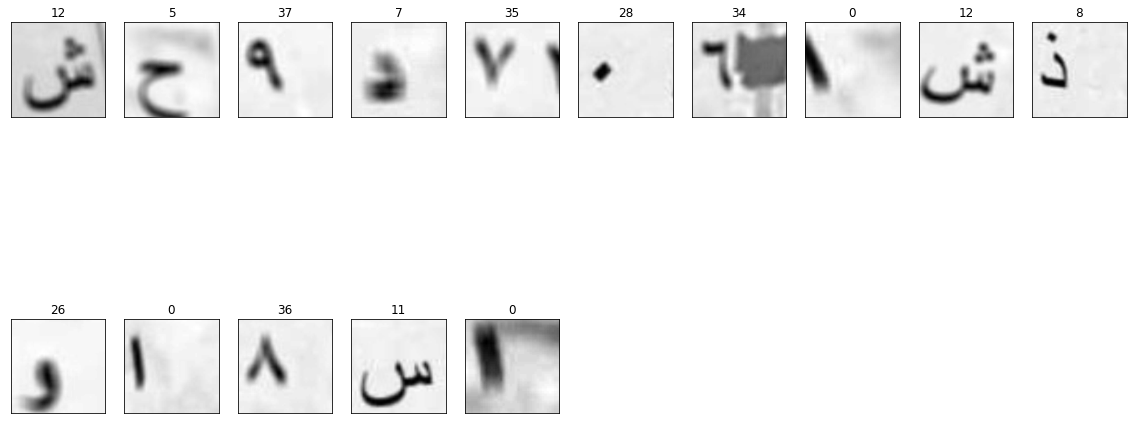

In [14]:
# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 10))
# display 15 images
for idx in range(15):
    ax = fig.add_subplot(2, int(20/2), idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(train_data.classes[labels[idx]])


# Defining model

### Loss Function & Optimizer

In [3]:
import torch.optim as optim
criterion = torch.nn.CrossEntropyLoss()
def get_optimizer(model):
    if use_cuda:
        model.cuda()
    optimizer = optim.Adam(model.parameters(),lr=0.001)
    return optimizer

NameError: name 'torch' is not defined

## Training & Testing Algorithms

In [ ]:
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        # set the module to training mode
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()

            ## record the average training loss, using something like
            optimizer.zero_grad()
            output = model(data)
            loss=criterion(output,target)
            loss.backward()
            optimizer.step()
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - train_loss))

        ######################    
        # validate the model #
        ######################
        # set the model to evaluation mode
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - valid_loss))

        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))

        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss
             
    return model

In [ ]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    # set the module to evaluation mode
    model.eval()

    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
#             model.cuda()
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))


### Model Architecture (VGG B-N)

In [5]:
import torchvision.models as models

In [6]:
vgg_model = models.vgg19_bn(pretrained=True)
print(vgg_model)

C:\Users\ZZ01H0865\Anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
C:\Users\ZZ01H0865\Anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG19_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [33]:
# freeze all weights
for param in vgg_model.features.parameters():
    param.requires_grad = False

In [7]:
vgg_model.classifier[6] = torch.nn.Linear(vgg_model.classifier[6].in_features,38)
print(vgg_model.classifier[6])

Linear(in_features=4096, out_features=38, bias=True)


## Resnet Model

In [12]:
resnet_model = models.resnext50_32x4d(pretrained=True)
print(resnet_model)

C:\Users\ZZ01H0865\Anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNeXt50_32X4D_Weights.IMAGENET1K_V1`. You can also use `weights=ResNeXt50_32X4D_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1

In [13]:
# by default the paramteres are freezed except the classification parameters
for param in resnet_model.parameters():
    param.requires_grad = False
print(resnet_model.fc)
resnet_model.fc = torch.nn.Linear(resnet_model.fc.in_features,38)
print(resnet_model.fc)


Linear(in_features=2048, out_features=1000, bias=True)
Linear(in_features=2048, out_features=38, bias=True)


## From scratch model

In [4]:
import torch.nn as nn
import torch.nn.functional as F
# define the CNN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        ## Define layers of a CNN

        self.conv1 = nn.Conv2d(3,32,5,padding=1)
        self.conv2 = nn.Conv2d(32,64,3,padding=1)
        self.pool = nn.MaxPool2d(2,2)
        self.fc1 = nn.Linear(56*56*32*64,512)
        self.fc2 = nn.Linear(512,256)
        self.fc3 = nn.Linear(256,38)
        
    
    def forward(self, x):
        ## Define forward behavior
        x=self.pool(F.tanh(self.conv1(x)))
        x= self.pool(F.relu(self.conv2(x)))
        x=x.view(-1,56*56*32*64)      
        x=F.dropout(F.leaky_relu(self.fc1(x),0.3),p=0.2)
        x=F.dropout(F.leaky_relu(self.fc2(x),0.2),p=0.5)
        x=F.softmax(self.fc3(x))
      
        return x

# instantiate the CNN
scratch_model = Net()

In [5]:
# weight initialization
def custom_weight_init(m):
    ## TODO: implement a weight initialization strategy
    classname = m.__class__.__name__
    if classname.find('Linear') !=-1:
        n=m.in_features
        y=1.0 / np.sqrt(n)
        m.weight.data.normal_(0,y)
        m.bias.data.fill_(0)
        
scratch_model.apply(custom_weight_init)

Net(
  (conv1): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=6422528, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=38, bias=True)
)

## Model training and evaluation

In [28]:
vgg_model = train(50, data_loaders, vgg_model, get_optimizer(vgg_model), 
                      criterion, use_cuda, 'vgg_model.pt')

# load the model that got the best validation accuracy
vgg_model.load_state_dict(torch.load('vgg_model.pt'))

Epoch: 1 	Training Loss: 0.991859 	Validation Loss: 0.225551
Validation loss decreased (inf --> 0.225551).  Saving model ...
Epoch: 2 	Training Loss: 0.673237 	Validation Loss: 0.728221
Epoch: 3 	Training Loss: 0.610880 	Validation Loss: 0.730866
Epoch: 4 	Training Loss: 0.533400 	Validation Loss: 0.011939
Validation loss decreased (0.225551 --> 0.011939).  Saving model ...
Epoch: 5 	Training Loss: 0.571375 	Validation Loss: 1.484024
Epoch: 6 	Training Loss: 0.533705 	Validation Loss: 0.601257
Epoch: 7 	Training Loss: 0.488745 	Validation Loss: 0.023419
Epoch: 8 	Training Loss: 0.548985 	Validation Loss: 0.975512
Epoch: 9 	Training Loss: 0.517079 	Validation Loss: 3.595272
Epoch: 10 	Training Loss: 0.556717 	Validation Loss: 0.268974
Epoch: 11 	Training Loss: 0.469435 	Validation Loss: 0.020653
Epoch: 12 	Training Loss: 0.463787 	Validation Loss: 0.313248
Epoch: 13 	Training Loss: 0.527690 	Validation Loss: 0.583639
Epoch: 14 	Training Loss: 0.498854 	Validation Loss: 0.416691
Epoch: 1

<All keys matched successfully>

In [23]:
for param in resnet_model.parameters():
    print(param.requires_grad)

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
True


In [24]:
torch.cuda.empty_cache()
resnet_model = train(30, data_loaders, resnet_model, get_optimizer(resnet_model), 
                      criterion, use_cuda, 'resnet_model.pt')
# load the model that got the best validation accuracy
resnet_model.load_state_dict(torch.load('resnet_model.pt'))

Epoch: 1 	Training Loss: 0.119027 	Validation Loss: 0.015062
Validation loss decreased (inf --> 0.015062).  Saving model ...
Epoch: 2 	Training Loss: 0.054139 	Validation Loss: 0.205160
Epoch: 3 	Training Loss: 0.056123 	Validation Loss: 0.000984
Validation loss decreased (0.015062 --> 0.000984).  Saving model ...
Epoch: 4 	Training Loss: 0.056383 	Validation Loss: 0.015323
Epoch: 5 	Training Loss: 0.053853 	Validation Loss: 0.006395
Epoch: 6 	Training Loss: 0.050764 	Validation Loss: 0.011083
Epoch: 7 	Training Loss: 0.049525 	Validation Loss: 0.303160
Epoch: 8 	Training Loss: 0.047716 	Validation Loss: 0.000066
Validation loss decreased (0.000984 --> 0.000066).  Saving model ...
Epoch: 9 	Training Loss: 0.046842 	Validation Loss: 0.381442
Epoch: 10 	Training Loss: 0.045921 	Validation Loss: 0.001228
Epoch: 11 	Training Loss: 0.047712 	Validation Loss: 0.000027
Validation loss decreased (0.000066 --> 0.000027).  Saving model ...
Epoch: 12 	Training Loss: 0.046751 	Validation Loss: 0.0

<All keys matched successfully>

In [6]:
torch.cuda.empty_cache()
scratch_model = train(30, data_loaders, scratch_model, get_optimizer(scratch_model),
                      criterion, use_cuda, 'scratch_model.pt')
scratch_model.load_state_dict(torch.load( 'scratch_model.pt'))

NameError: name 'torch' is not defined

In [16]:
torch.cuda.empty_cache()
vgg_model.load_state_dict(torch.load('vgg_model.pt',map_location=torch.device('cpu')))


<All keys matched successfully>

In [15]:
resnet_model.load_state_dict(torch.load('resnet_model.pt',map_location=torch.device('cpu')))

RuntimeError: [enforce fail at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\caffe2\serialize\inline_container.cc:250] . file in archive is not in a subdirectory archive/: sample_submissions.csv

In [38]:
test(data_loaders, vgg_model, criterion, use_cuda)

Test Loss: 0.081670


Test Accuracy: 99% (22378/22457)


In [25]:
test(data_loaders, resnet_model, criterion, use_cuda)

Test Loss: 0.013843


Test Accuracy: 99% (22360/22457)


In [ ]:
test(data_loaders, scratch_model, criterion, use_cuda)